# Exploratory Data Analysis

## Gathering Data and imports

In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer/sample_submission.csv
/kaggle/input/customer/Train.csv
/kaggle/input/customer/Test.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Installing spark and Creating a Spark Session

In [ ]:
# Installing pyspark
!pip install pyspark
import pyspark.sql.functions as f
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Multiclass Classification').getOrCreate()

### Loading the Train.csv Dataset into a spark DataFrame

In [ ]:
df = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/kaggle/input/customer/Train.csv')
df.limit(10).toPandas().style.hide(axis="index")

In [5]:
catg_cols = []
num_cols = []
for cols in df.dtypes:
    if cols[1] == 'string' and cols[0] != 'Segmentation':
        catg_cols.append(cols[0])
    elif cols[1] != 'string' and cols[0] != 'ID':
        num_cols.append(cols[0])

print('Categorical columns are: ',*catg_cols)
print('Numerical columns are:',*num_cols)

Categorical columns are:  Gender Ever_Married Graduated Profession Spending_Score Var_1
Numerical columns are: Age Work_Experience Family_Size


## Summary statistics of Numerical / Continuous columns


In [21]:
spark.conf.set("spark.sql.debug.maxToStringFields", 50)
df.select(*num_cols).summary().toPandas()

,summary,Age,Work_Experience,Family_Size
0,count,8068,7239,7733
1,mean,43.46690629647992,2.641663213150988,2.85012285012285
2,stddev,16.71169631872117,3.4067629854580828,1.5314132820253776
3,min,18,0.0,1.0
4,25%,30,0.0,2.0
5,50%,40,1.0,3.0
6,75%,53,4.0,4.0
7,max,89,14.0,9.0


#### **Here we can observe the following:**
- Customer Age ranges from 18 to 89 with mean of 43.46
- Work Experience range from 0 to 14 Years with mean of 2.64
- Family Size range from 1 to 9 with mean of 2.8

### Finding out missing values in the data

In [7]:
print('Total rows in dataset: ',df.count())

Total rows in dataset:  8068


In [8]:
print('Null Values in each column: ')
df.select([f.count(f.when(f.isnan(c) | f.col(c).isNull(),c)).alias(c) for c in df.columns]).toPandas().style.hide(axis="index")

Null Values in each column: 


ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,0,140,0,78,124,829,0,335,76,0


### Removing null values for accurate visualization of data

In [9]:
df_nr = df.na.drop()
print('Rows in dataset after removing nulls: ',df_nr.count())

Rows in dataset after removing nulls:  6665


We can deal with missing data by imputation later when modelling

## Visualizations - Univariate and Bivariate Analysis

### Plotting Numerical Columns

In [10]:
pdf = df_nr.toPandas()

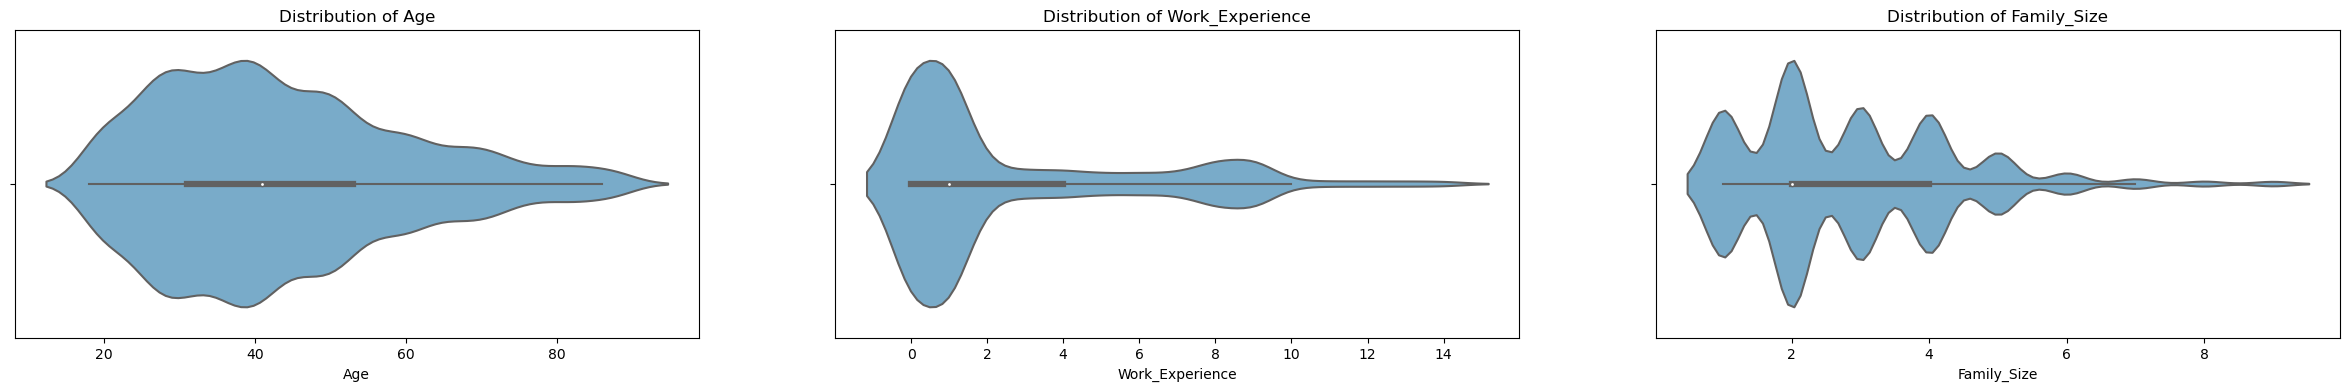

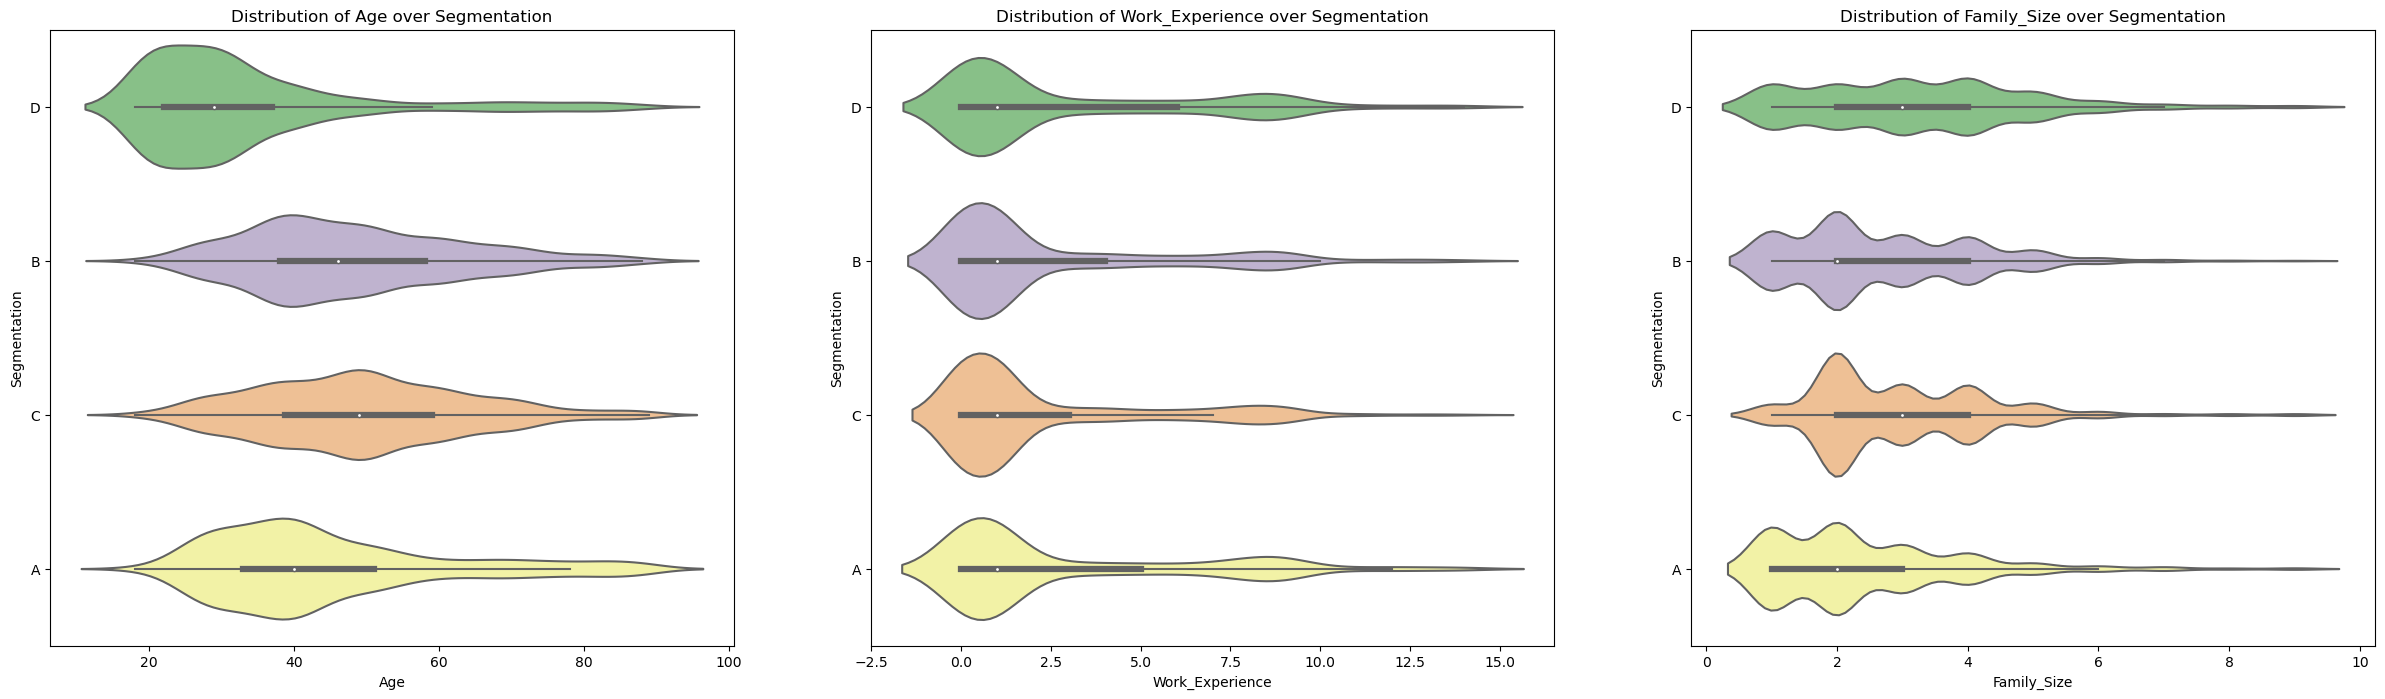

In [26]:
fig, ax = plt.subplots(1,3, figsize=(30,4))
for i, subplots in zip(num_cols, ax.flatten()):
    sns.violinplot( x=pdf[i], ax=subplots, palette='Blues_r').set_title(f'Distribution of {i}')
    
fig, ax = plt.subplots(1,3, figsize=(30,8))
for i, subplots in zip(num_cols, ax.flatten()):
    sns.violinplot(x=i, y='Segmentation', data=pdf, ax=subplots, palette='Accent').set_title(f'Distribution of {i} over Segmentation')

#### **Following observations can be derived from the above plots:**
- Age looks closer to a normal distribution, with median close to 40
- If we look at distribution of age over segmentation: 
    - 'D' Has younger customers with median age between 20-40
    - 'A' customers with median age 40
    - 'B' And 'C' are identical with respect to age, their median is close to 50  <br><br>
- Maximum population has Work experience less than 2 years  
- Experience is identical over all segments as the median does not shift  <br><br>
- Maximum population has fimily size less than 5, with a spike at 2  
- If we look closely at distribution of family sizer over segments:  
    - 'D' follows a uniform distribution till 4, with median size close to 3  
    - 'B' and 'A' has median close to 2, range of A is lowest compared to others  
    - 'C' has median close to 3, with a spike at 2

### Plotting Categorical Columns

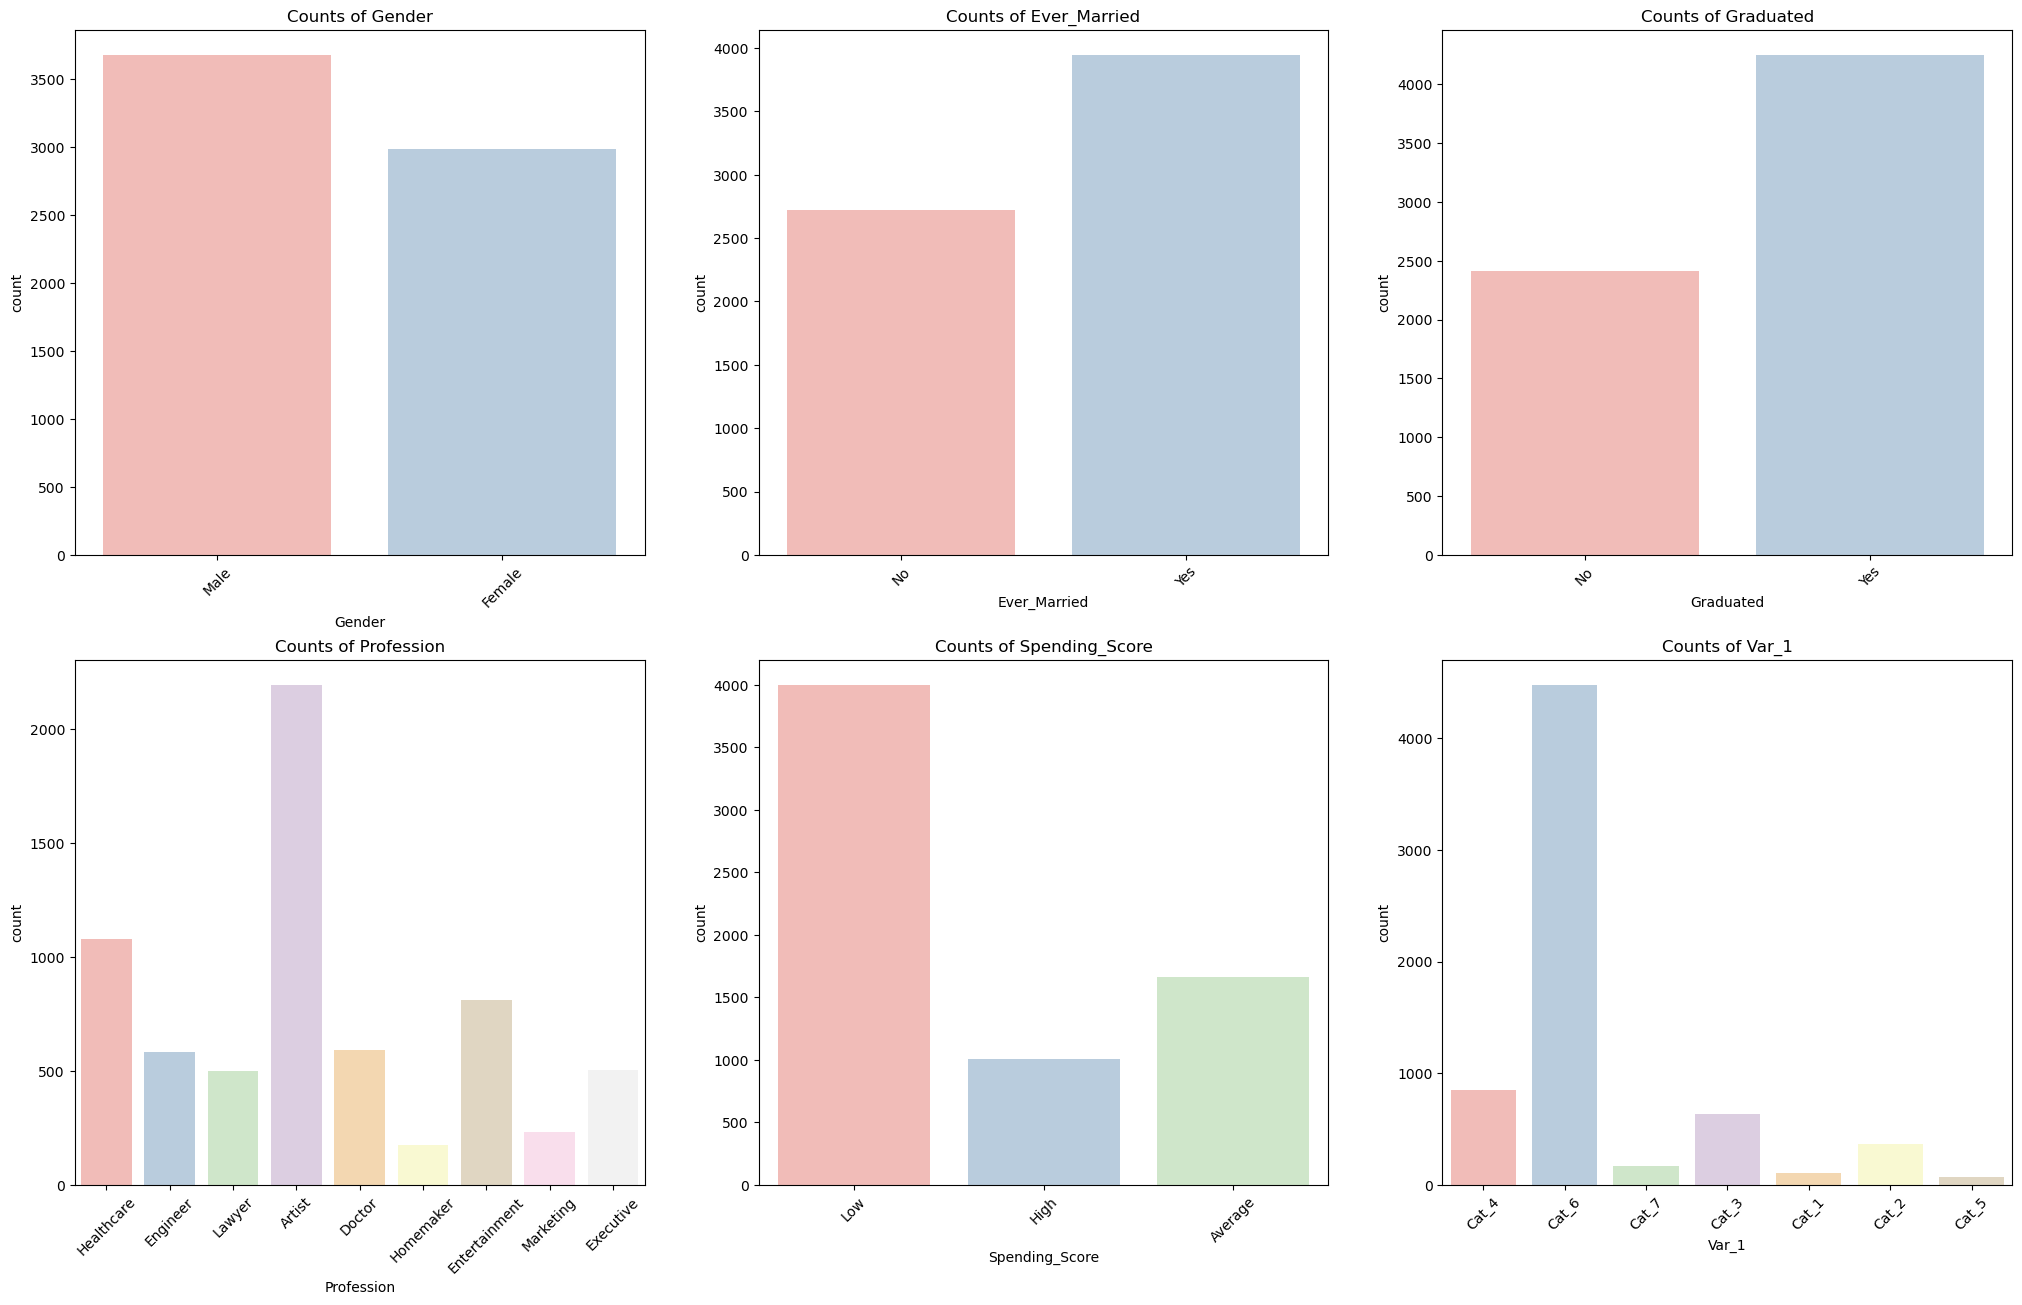

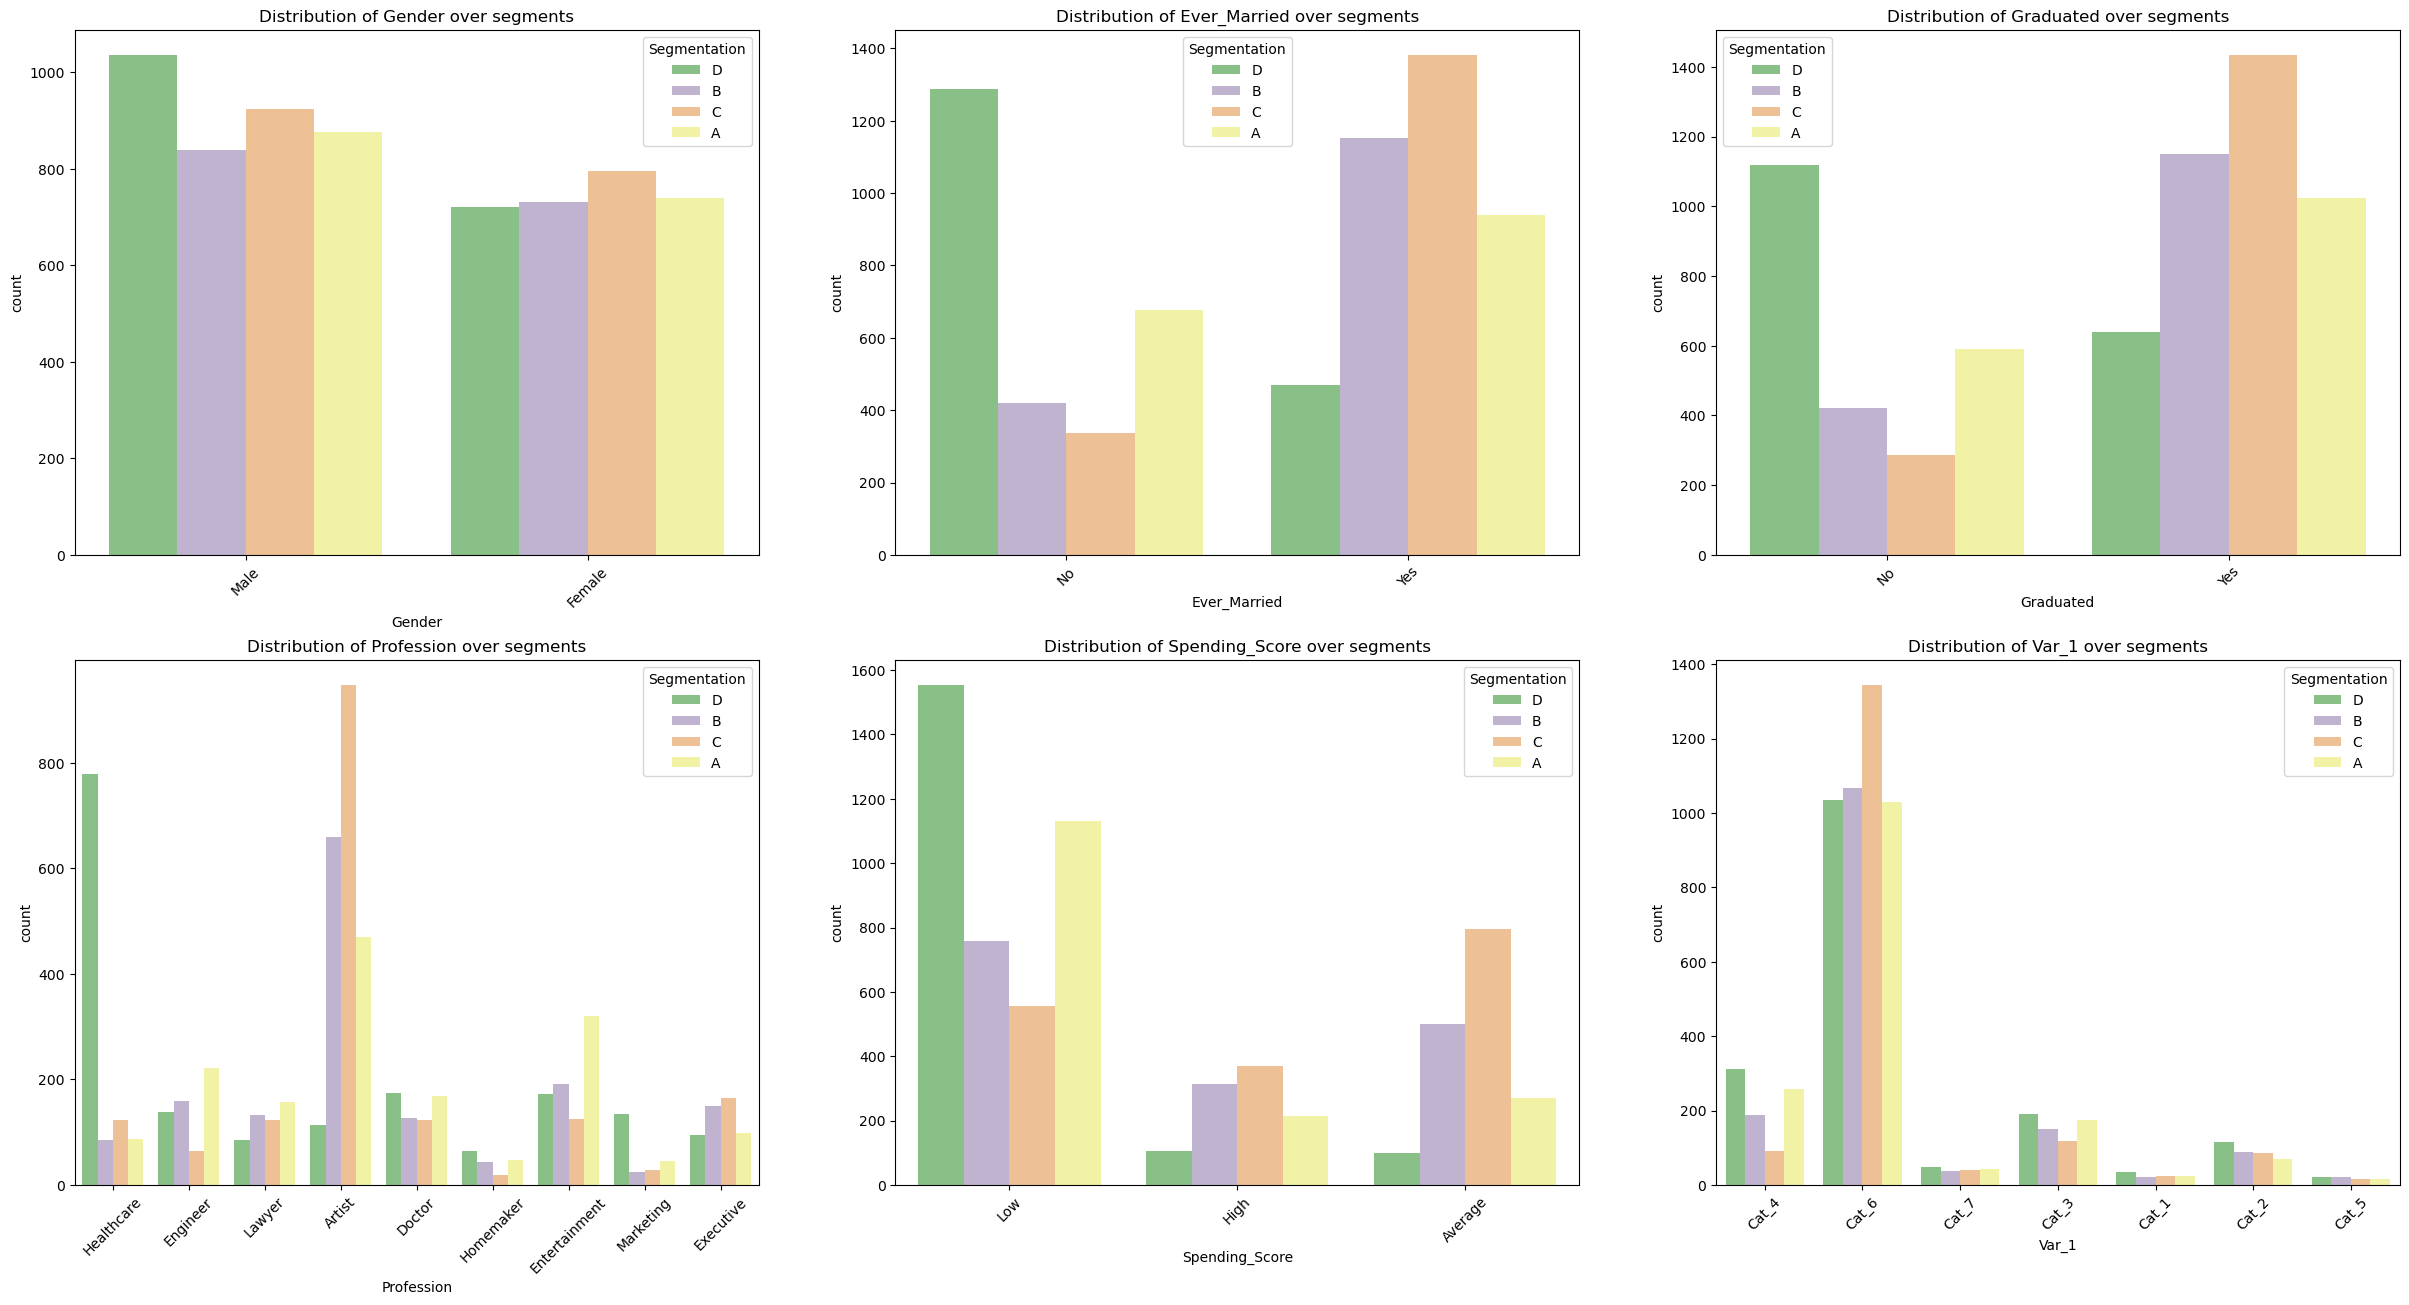

In [12]:
fig, ax = plt.subplots(2,3, figsize=(25,15))
for i, subplots in zip(catg_cols, ax.flatten()):
    sns.countplot( x=pdf[i], ax=subplots, palette='Pastel1').set_title(f'Counts of {i}')
    subplots.tick_params(axis='x', rotation=45)
    
fig, ax = plt.subplots(2,3, figsize=(30,15))
for i, subplots in zip(catg_cols, ax.flatten()):
    sns.countplot( x=i,data=pdf,hue='Segmentation', ax=subplots, palette='Accent').set_title(f'Distribution of {i} over segments')
    subplots.tick_params(axis='x', rotation=45)

#### Following Observations can be derived from the plots above
- **Gender** : Male population is slightly higher than female  
    - All segments are equally distributed between male and female  <br><br> 
- **Ever_Married** : Counts of married people are higher  
    - Segment D seems to have more number of unmarried customers  
    - Segment B and C have more number of married customers  <br><br>
- **Graduated** : Counts of graduated people are higher  
    - Segment D seems to have higher number of non graduated customers  
    - Segment B and C have more number of graduated customers  <br><br>
- **Profession** : Highest number of customers are artists, and Hommemakers being the least  
    - Segment C seems to have highest number of Artists  
    - Segment D have highest number of Helthcare and Marketing professionals compared to others  
    - Segment A has highest number of customers in Entertainment  <br><br>
- **Spending Score** : Most customers are low spenders  
    - Segment D and A spend the lowest among other segments  
    - Segment B and C have equal number of customer spread over high, avg and low spending score  <br><br> 
- **Var_1** (Anonimized categories for customer): Most customers fall in category 6, and least being category 5  
    - Segment C have highest customers in categoty 6  
    - Other categories are almost equally distributed  

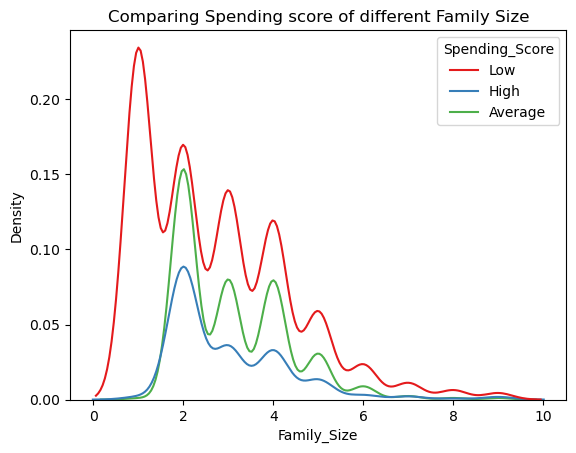

In [13]:
sns.kdeplot(data=pdf, x='Family_Size', hue='Spending_Score', palette='Set1').set_title('Comparing Spending score of different Family Size')
plt.show()

#### Observations
- All customers with Family size = 1 are low spenders
- Even if family size increases, the low spending customers are dominating
    - Which means, people are spending less even though their family is big
    - This could be a good opportunity to target customers with higher family size to increase revenue

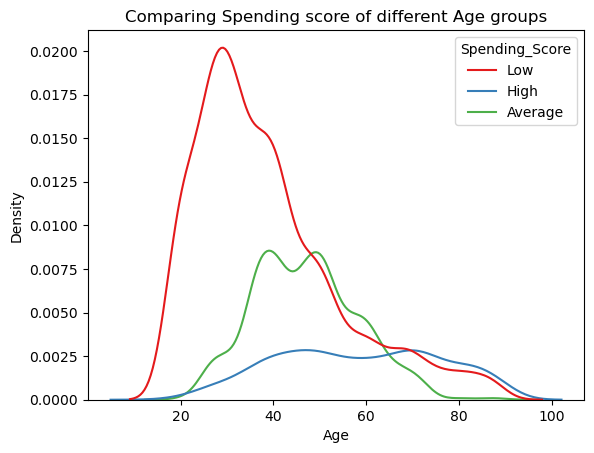

In [14]:
sns.kdeplot(data=pdf, x='Age', hue='Spending_Score', palette='Set1').set_title('Comparing Spending score of different Age groups')
plt.show()

#### Observations
- Customers with age less than 50 are mostly low spenders
- After age 65 the % of High spenders are highest
    - This could be a opportunity to focus more on customers with Age less than 40, and increase their revenue

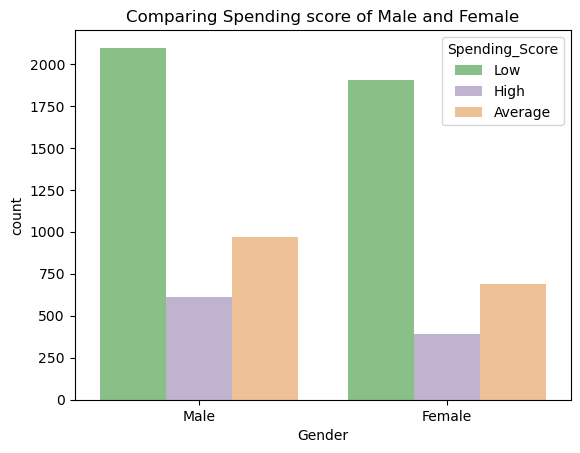

In [15]:
sns.countplot(data=pdf, x='Gender', hue='Spending_Score', palette='Accent').set_title('Comparing Spending score of Male and Female')
plt.show()

#### Observations
- The distribution is same for both male and females
- Spending pattern is same irrespective of gender
    - This could be a good opportunity to target females for BPC products (Beauty and Personal Care) to increse revenue

### Plotting Label (Segmentation)

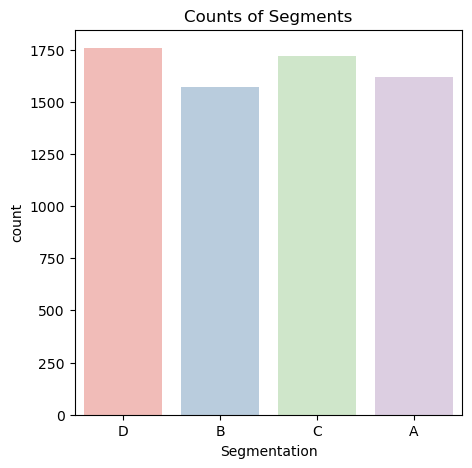

In [16]:
plt.figure(figsize=(5,5))
sns.countplot(x=pdf['Segmentation'],  palette='Pastel1').set_title(f'Counts of Segments')
plt.show()

**The Segmentation Column is equally distributed, Hence we wont need to perform subsampling later**

## Multivariate Analysis

#### Looking at Age vs Years of Experice

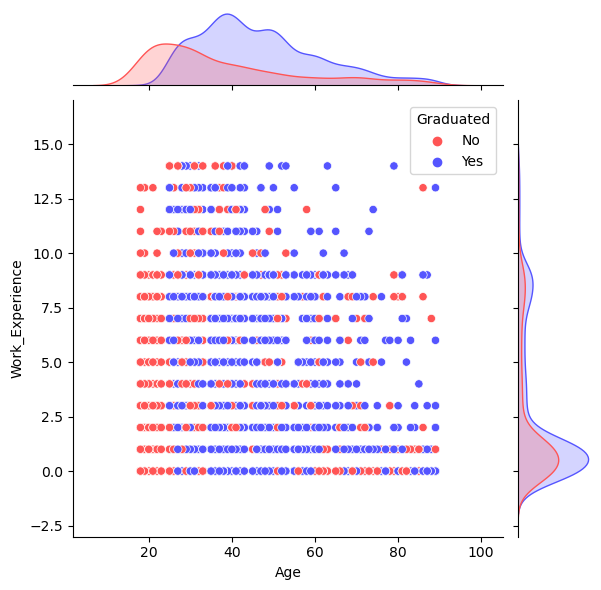

In [17]:
sns.jointplot(data=pdf, x='Age',y='Work_Experience', hue='Graduated', palette='seismic_r')
plt.show()

#### Observations
- Age has negative effect on Work_experience, this was unexpected, I was expecting a left skewed distribution where Work_experience increase when age increases
- Strangely people with Age 18 have 13 years of experience
- More people are graduated after age 30
- Work_Experience has no effect of Graduation

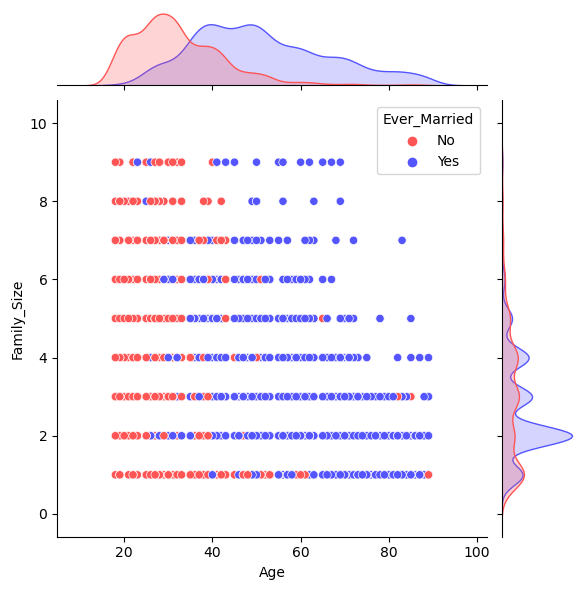

In [18]:
sns.jointplot(data=pdf, x='Age',y='Family_Size', hue='Ever_Married', palette='seismic_r')
plt.show()

#### Observations
- Age has negative relation with Family_Size in this data
- Family size decreases after age of 40
- Most customers are unmarried before age of 35

## Plotting Correlation matrix between the Numerical Columns

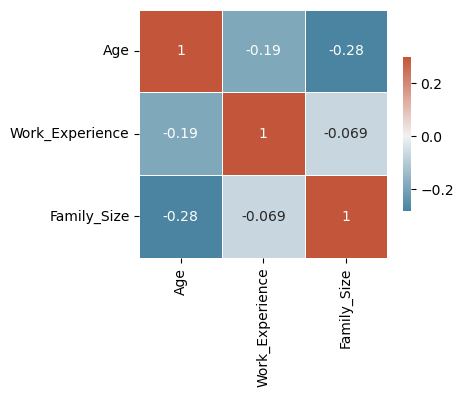

In [19]:
# Compute the correlation matrix
corr = pdf[num_cols].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(4, 4))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

**Numerical Columns are not highly correlated with each other**
- All columns have negative correlation
- As we have seen from the joint plot Age and Family size, Age and Work experience are negatively correlated

## Predictive Power Of features using PPScore

In [ ]:
!pip install ppscore
import ppscore as pps

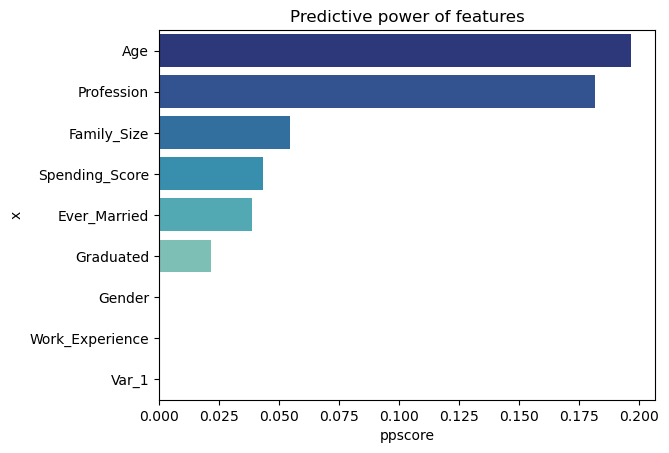

In [28]:
pps_scores = pps.predictors(pdf.drop('ID', axis=1), y="Segmentation")[['x','y','ppscore']]
sns.barplot(data=pps_scores, y='x',x='ppscore', palette='YlGnBu_r').set_title('Predictive power of features')
plt.show()

#### Age and Profession have the highest predictive power